In [1]:
%load_ext autoreload
%autoreload 2

import os


import sys

import scipy
import scipy.io
import time

import os.path
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE"


import tensorflow as tf
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "/home/vlq26735/code/PhD/GradientPathologiesPINNs/checkpoints/1DWave/"
MODE = "M1"

src_path = os.path.abspath(os.path.join('../../'))
print(f"src_path= {src_path}")

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from src.cases.Wave import M1



src_path= /home/vlq26735/code/PhD/GradientPathologiesPINNs


In [2]:

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y



# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) -  a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) -  a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)



In [3]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), name='coll')



nIter =1000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M1'
layers = [2, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]



# [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )
tf.reset_default_graph()
gpu_options = tf.GPUOptions(visible_device_list="0")
sess =  tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False))
# sess.run(init)

model = M1.PINN(layers ,  ics_sampler, bcs_sampler, res_sampler, c , mode , CHECKPOINT_PATH , sess)
# Train model
start_time = time.time()

model.print("mini_batch method is used")
model.trainmb(nIter, mbbatch_size)

elapsed = time.time() - start_time

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(u_star, 2)

model.print('elapsed: {:.2e}'.format(elapsed))

model.print('Relative L2 error_u: {:.2e}'.format(error_u))
model.print('Relative L2 error_r: {:.2e}'.format(error_r))

model.save_NN()
model.plot_grad()
model.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)


2024-02-28 08:13:53.871076: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 08:13:53.997104: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2445400000 Hz
2024-02-28 08:13:53.997394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561b362d60e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-28 08:13:53.997423: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-28 08:13:53.997626: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


mini_batch method is used
It: 0, Loss: 4.305e+04, Loss_res: 4.301e+04,  Loss_bcs: 3.276e+01, Loss_ut_ics: 4.545e+00,, Time: 58.84
mean_grad_res: 1.751e+03
mean_grad_ics: 3.033e-01
mean_grad_bcs: 1.519e+00
Gradients information stored ...
It: 100, Loss: 1.620e+00, Loss_res: 1.171e+00,  Loss_bcs: 4.438e-01, Loss_ut_ics: 4.728e-03,, Time: 354.97
Gradients information stored ...
It: 200, Loss: 5.381e-01, Loss_res: 1.180e-01,  Loss_bcs: 4.107e-01, Loss_ut_ics: 9.453e-03,, Time: 560.57
It: 300, Loss: 5.066e-01, Loss_res: 9.134e-02,  Loss_bcs: 4.041e-01, Loss_ut_ics: 1.125e-02,, Time: 678.84
It: 400, Loss: 5.532e-01, Loss_res: 1.720e-01,  Loss_bcs: 3.702e-01, Loss_ut_ics: 1.102e-02,, Time: 796.68
It: 500, Loss: 9.730e-01, Loss_res: 6.118e-01,  Loss_bcs: 3.498e-01, Loss_ut_ics: 1.140e-02,, Time: 913.50
It: 600, Loss: 4.112e-01, Loss_res: 7.259e-02,  Loss_bcs: 3.281e-01, Loss_ut_ics: 1.049e-02,, Time: 1030.42
It: 700, Loss: 3.905e-01, Loss_res: 2.116e-02,  Loss_bcs: 3.576e-01, Loss_ut_ics: 1.17

In [4]:



plot_grad(model , )

NameError: name 'plot_grad' is not defined

In [11]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(u_star, 2)

In [5]:
# # Predictions
# u_pred = model.predict_u(X_star)
# r_pred = model.predict_r(X_star)
# # Predictions
# r_pred =r_pred.reshape(200,200)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
# error_r = np.linalg.norm(r_star - r_pred, 2)# / np.linalg.norm(r_star, 2)

# print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))
# print('Relative L2 error_r: {:.2e}'.format(error_r))
# r_pred =r_pred.reshape(200,200)


NameError: name 'u_pred' is not defined

TypeError: Dimensions of C (40000, 1) are incompatible with X (200) and/or Y (200); see help(pcolor)

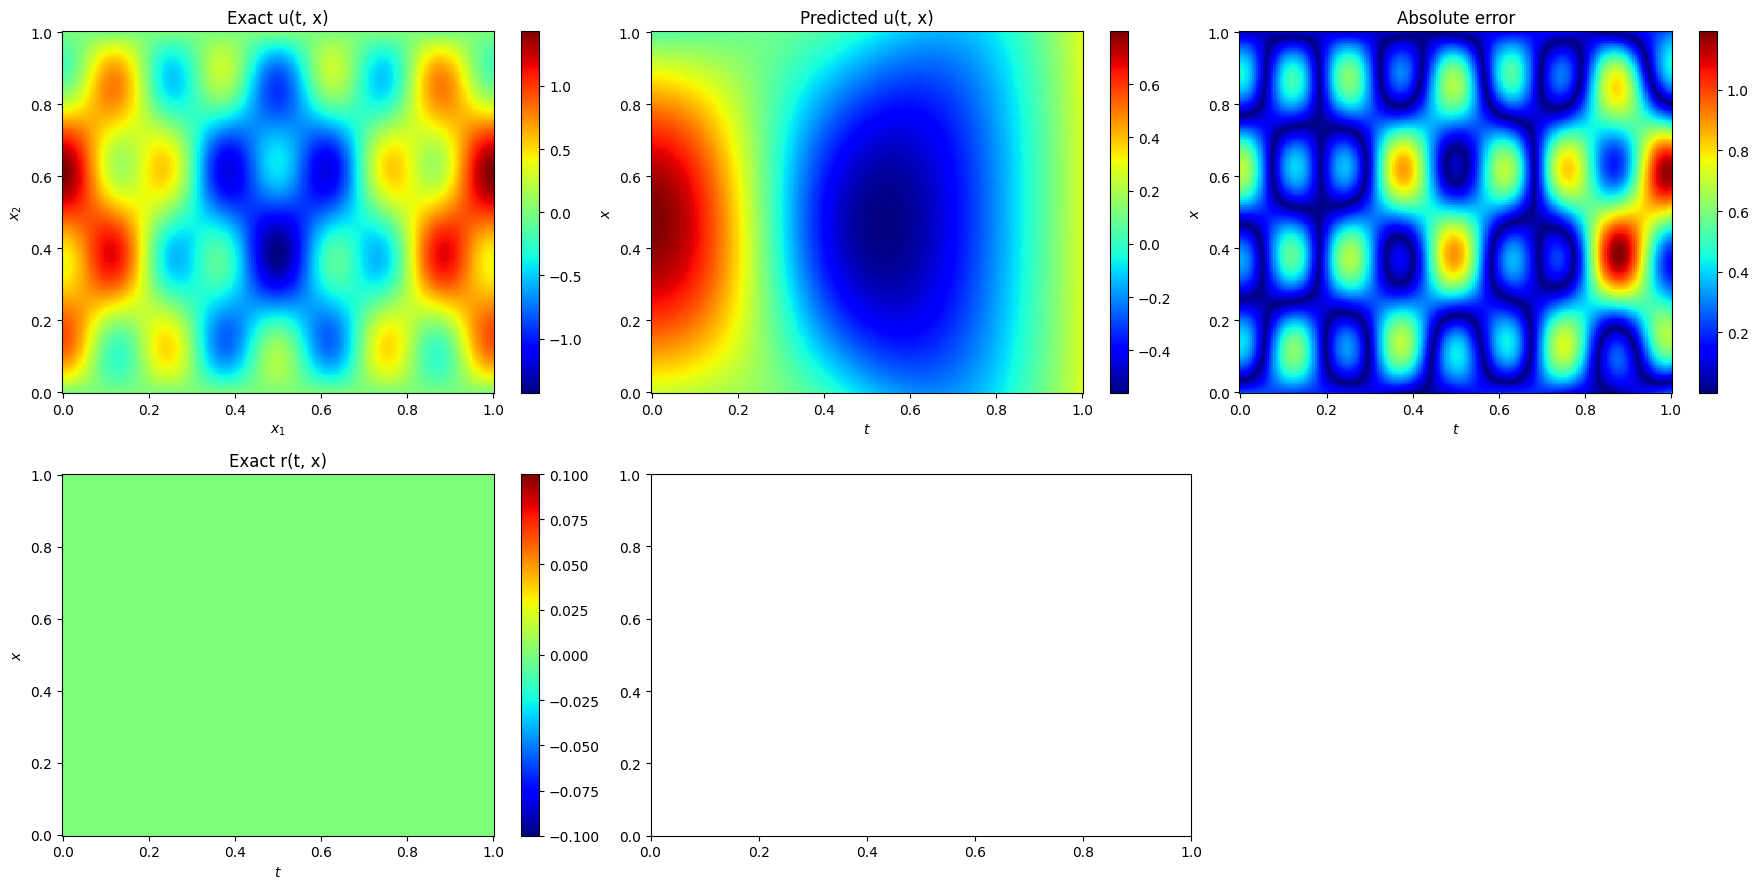

In [4]:

U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
# R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, r_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - r_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()